In [3]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jre_utils.datapath import model_ready_data_paths

from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [9]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric = metrics["median"]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
upcoming_metric_pct_chg = "upcoming_" + metric_pct_chg
normalized_upcoming_metric_pct_chg = "normalized_" + "upcoming_" + metric_pct_chg

In [10]:
dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"xgb_{dataset_key}"]
df = pd.read_csv(model_ready_data_path)
df[normalized_upcoming_metric_pct_chg] = df.groupby("year")[
    upcoming_metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

In [11]:
y_columns = ["return_classes"]

X_categorical_columns = ["area_code", "area"]

X_basic_columns = [
    "year",
    "population",
    "count",
    "taxable_income_per_taxpayer",
    "taxable_income_per_taxpayer_growth",
]

X_engineering_columns = [
    "net_migration_ratio",
    "taxable_income_growth",
    "new_dwellings_ratio",
    metric_pct_chg,
]

X_engineered_columns = [
    "net_migration_ratio_ma3",
    "net_migration_ratio_cumu3",
    "net_migration_ratio_lag1",
    "taxable_income_growth_ma3",
    "taxable_income_growth_cumu3",
    "taxable_income_growth_lag1",
    "new_dwellings_ratio_ma3",
    "new_dwellings_ratio_cumu3",
    "new_dwellings_ratio_lag1",
    "unit_price_median_pct_chg_ma3",
    "unit_price_median_pct_chg_cumu3",
    "unit_price_median_pct_chg_lag1",
]

X_columns = (
    X_categorical_columns
    + X_basic_columns
    + X_engineering_columns
    + X_engineered_columns
)

In [22]:
# boundary = 0.1
boundary = 0.3

bins = pd.IntervalIndex.from_tuples(
    [
        (-np.inf, -boundary),
        (-boundary, boundary),
        (boundary, np.inf),
    ]
)

labels = ["Negative", "Neutral", "Positive"]
# df["return_classes"] = pd.cut(df[upcoming_metric_pct_chg], bins).map(
#     dict(zip(bins, range(len(labels))))
# )
df["return_classes"] = pd.cut(df[normalized_upcoming_metric_pct_chg], bins).map(
    dict(zip(bins, range(len(labels))))
)
df["return_classes"] = df["return_classes"].astype(int)
df["return_classes"].value_counts()

return_classes
1    7947
0    7653
2    4264
Name: count, dtype: int64

In [23]:
divide_year = 2020 # test_years = [2021]
train_df = df[df["year"] <= divide_year]
test_df = df[df["year"] > divide_year]

drop_columns = ["year", "area_code", "area"]
X_train_df, X_test_df = train_df[X_columns].drop(columns=drop_columns), test_df[X_columns].drop(columns=drop_columns)
y_train_df, y_test_df = train_df[y_columns], test_df[y_columns]

In [24]:
xgb_classifier = XGBClassifier(
    tree_method="hist", early_stopping_rounds=2, enable_categorical=True
)
xgb_classifier.fit(X_train_df, y_train_df, eval_set=[(X_test_df, y_test_df)])

y_train_pred = xgb_classifier.predict(X_train_df)
y_test_pred = xgb_classifier.predict(X_test_df)

print(f"Train Accuracy: {accuracy_score(y_train_df.values.squeeze(), y_train_pred):.3f}")
print(f"Test Accuracy: {accuracy_score(y_test_df.values.squeeze(), y_test_pred):.3f}")

[0]	validation_0-mlogloss:1.01772
[1]	validation_0-mlogloss:0.97001
[2]	validation_0-mlogloss:0.94011
[3]	validation_0-mlogloss:0.92116
[4]	validation_0-mlogloss:0.91003
[5]	validation_0-mlogloss:0.90364
[6]	validation_0-mlogloss:0.89602
[7]	validation_0-mlogloss:0.89202
[8]	validation_0-mlogloss:0.88876
[9]	validation_0-mlogloss:0.88836
[10]	validation_0-mlogloss:0.88777
[11]	validation_0-mlogloss:0.88835
[12]	validation_0-mlogloss:0.88760
[13]	validation_0-mlogloss:0.88861
[14]	validation_0-mlogloss:0.88841
Train Accuracy: 0.666
Test Accuracy: 0.589


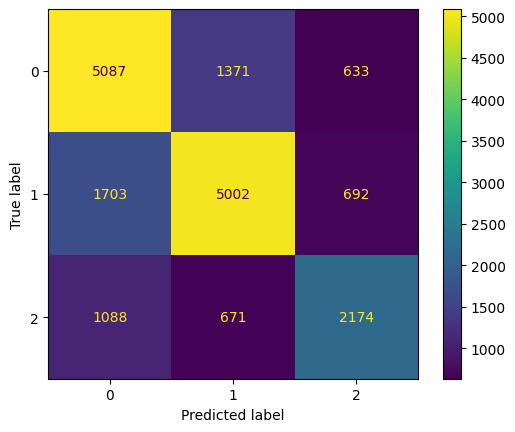

In [25]:
cm = confusion_matrix(y_train_df.values.squeeze(), y_train_pred, labels = xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_classifier.classes_)
disp.plot()

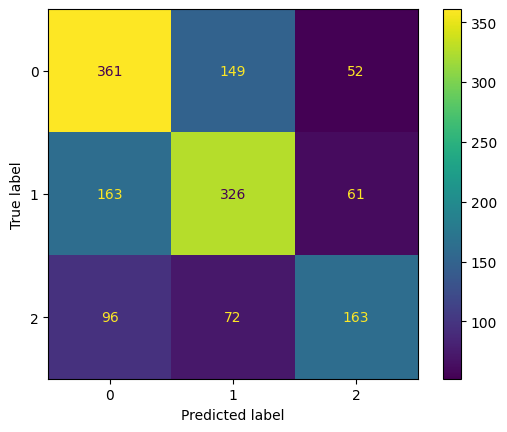

In [26]:
cm = confusion_matrix(y_test_df.values.squeeze(), y_test_pred, labels = xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_classifier.classes_)
disp.plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

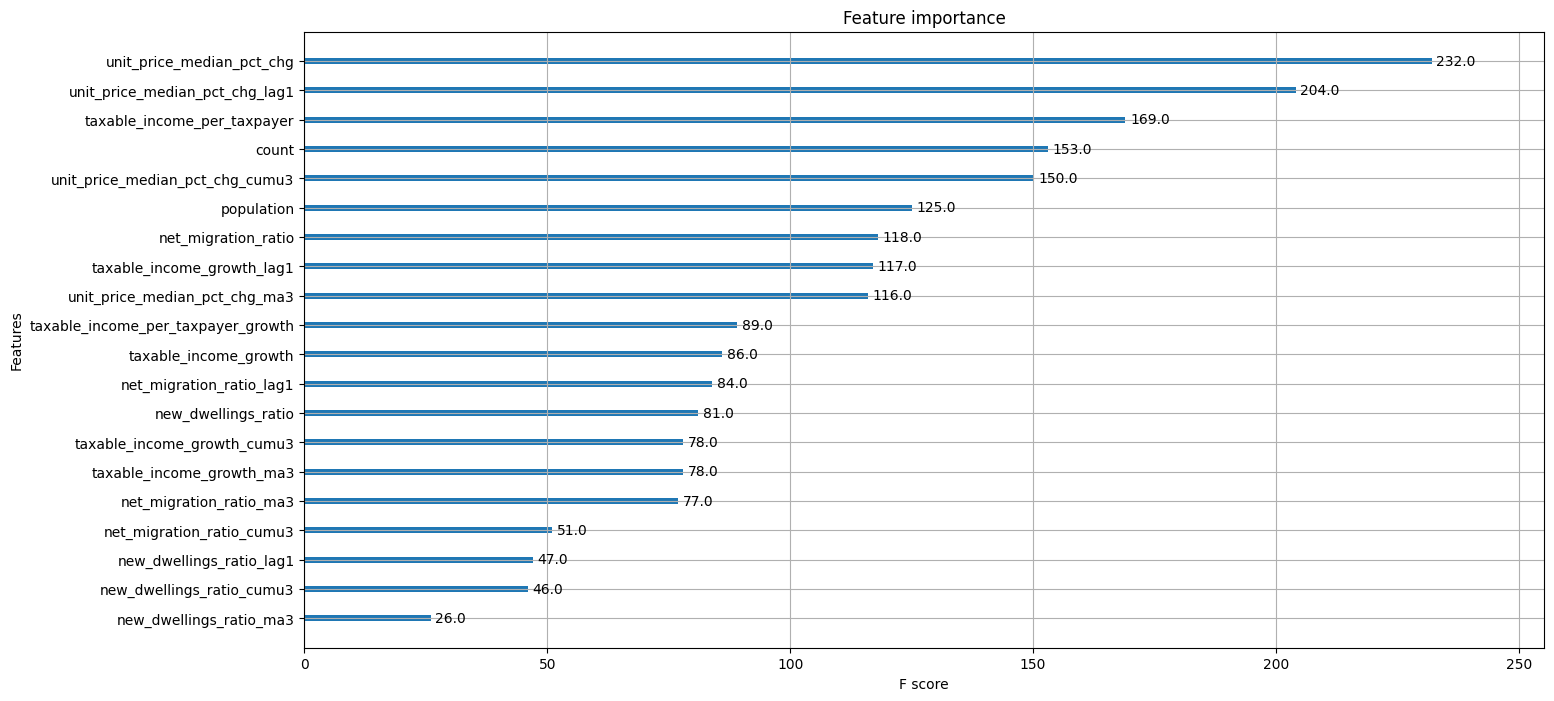

In [10]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_classifier)

In [11]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_df["predicted_return_classes"] = pd.Series(xgb_classifier.predict(presentation_df[X_columns].drop(columns=drop_columns)))
presentation_df["upcoming_return"] = presentation_df[upcoming_metric_pct_chg]
presentation_df["upcoming_return_classes"] = presentation_df["return_classes"].map(dict(enumerate(labels)))
presentation_df["predicted_return_classes"] = pd.Series([labels[i] for i in xgb_classifier.predict(presentation_df[X_columns].drop(columns=drop_columns))], index = presentation_df.index)

presentation_df = presentation_df.sort_values(by=upcoming_metric_pct_chg, ascending=False).reset_index(drop=True)
presentation_df[["area", "count", "upcoming_return", "upcoming_return_classes", "predicted_return_classes"]].style.background_gradient(cmap="cividis")

,area,count,upcoming_return,upcoming_return_classes,predicted_return_classes
0,Tokyo-to Mizuho-machi,41.000000,0.444444,Positive,Neutral
1,Tokyo-to Chuo-ku,80.000000,0.434898,Positive,Neutral
2,Tokyo-to Taito-ku,126.000000,0.320192,Positive,Neutral
3,Tokyo-to Chiyoda-ku,48.000000,0.295499,Positive,Neutral
4,Tokyo-to Akishima-shi,89.000000,0.272727,Positive,Neutral
5,Tokyo-to Sumida-ku,190.000000,0.253468,Positive,Neutral
6,Tokyo-to Higashiyamato-shi,99.000000,0.227381,Positive,Neutral
7,Tokyo-to Tama-shi,92.000000,0.225165,Positive,Neutral
8,Tokyo-to Kita-ku,252.000000,0.217873,Positive,Neutral
9,Tokyo-to Bunkyo-ku,139.000000,0.215217,Positive,Neutral
